<a href="https://colab.research.google.com/github/roque-alfaro/taller-eiv-2026/blob/main/5_Ejercicio_ETL_(R).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio:

Utilizando los datos de interconsultas del SSMN entre 2019 y 2023, cree un flujo de Extracción, Transformación y Carga para responder: ¿Cuál fue la demanda de interconsultas de Gastroenterología y Coloproctología por centro entre 2019 y 2024?


# Configurar área de trabajo y cargar datos
Por desgracia, en Google Colab no podemos usar las librerías de [Plotly](https://plotly.com/graphing-libraries/) para construir gráficos interactivos. ¡Pero podemos utilizar `ggplot` para construir gráficos estáticos que ayuden a apoyar nuestras presentaciones! 📊✨.

In [1]:
#borrar objetos previos
rm(list=ls())
#borrar figuras (si hay)
while(!dev.cur())dev.off()
cat("\014")

# Marcados con '#' es código que se computa. Queda como comentario

# importar librerías, si no existe, la cargamos del repositorio CRAN último (más estable),
# sin dependencias (FALSE), para no colapsar las exigencias del entorno virtual
if(!require("nanoparquet")) {
  install.packages("nanoparquet",
    dependencies = FALSE,
    repos = "https://packagemanager.posit.co/cran/latest",
    quiet=T)
}
# Cargamos librerías para leer excels, manipular datos y generar figuras
if (!require(readxl)){install.packages("readxl", repos = "https://packagemanager.posit.co/cran/latest");require(readxl)}
if (!require(dplyr)){install.packages("dplyr", repos = "https://packagemanager.posit.co/cran/latest");require(dplyr)}
if (!require(ggplot2)){install.packages("ggplot2", repos = "https://packagemanager.posit.co/cran/latest");require(ggplot2)}
# definir carpetas de trabajo
datos_crudos_interconsultas <- 'https://raw.githubusercontent.com/rlagosb/taller_eiv/main/datos_crudos/Solicitud%20Informaci%C3%B3n%20LT-AO008T00001801.parquet'
path_dw <- 'https://raw.githubusercontent.com/rlagosb/taller_eiv/main/datos_multidimensionales/Data_Warehouse_Dims.xlsx'

Loading required package: nanoparquet

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘nanoparquet’”
Loading required package: readxl

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2



# Extraer

Explique a continuación qué es lo que hace este bloque de código:

In [2]:
#sic_raw = pd.read_parquet(datos_crudos_interconsultas)
#definimos carpeta donde bajamos el archivo datos_crudos_interconsultas
dest_crdos_int <- tempfile(fileext = ".parquet")
#luego, bajamos el archivo
download.file(
    datos_crudos_interconsultas,
    dest_crdos_int,
    mode  = "wb",
    quiet = TRUE
)
#luego, lo cargamos
sic_raw <- nanoparquet::read_parquet(dest_crdos_int)
#finalmente, vemos información general de él (un vistazo)
dplyr::glimpse(sic_raw)

Rows: 398,520
Columns: 6
$ SEXO       <dbl> 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2,…
$ TIPO_PREST <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ PRESTA_MIN <chr> "07-041", "09-011", "09-011", "07-044", "07-066", "07-066",…
$ F_ENTRADA  <dttm> 2019-01-11, 2019-01-08, 2019-01-08, 2019-01-11, 2019-01-09…
$ ESTAB_DEST <dbl> 109101, 109100, 109100, 109309, 109100, 109100, 109101, 109…
$ EDAD       <dbl> 3, 35, 35, 27, 27, 22, 6, 14, 77, 56, 62, 37, 0, 60, 76, 83…


# Transformar SIC

In [5]:
names(sic_raw)


[1] "SEXO"       "TIPO_PREST" "PRESTA_MIN" "F_ENTRADA"  "ESTAB_DEST"
[6] "EDAD"

In [6]:
sic <- sic_raw

# Generamos columnas Año y Mes
sic$Año <- as.POSIXlt(sic$F_ENTRADA)$year + 1900
sic$Mes <- as.numeric(format(sic$F_ENTRADA, "%m"))

# Agrupamos por sexo, prestación, centro destino, edad, año y mes
sic <- dplyr::group_by(
  sic,
  SEXO,
  PRESTA_MIN,
  ESTAB_DEST,
  EDAD,
  Año,
  Mes
) %>%
  dplyr::summarise(
    n = n(),
    .groups = "drop"
  )


In [7]:
head(sic)
glimpse(sic)


SEXO,PRESTA_MIN,ESTAB_DEST,EDAD,Año,Mes,n
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,07-002,109101,0,2020,1,3
1,07-002,109101,0,2020,2,1
1,07-002,109101,0,2020,4,1
1,07-002,109101,0,2020,6,1
1,07-002,109101,0,2020,7,1
1,07-002,109101,0,2020,9,2


Rows: 188,811
Columns: 7
$ SEXO       <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ PRESTA_MIN <chr> "07-002", "07-002", "07-002", "07-002", "07-002", "07-002",…
$ ESTAB_DEST <dbl> 109101, 109101, 109101, 109101, 109101, 109101, 109101, 109…
$ EDAD       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ Año        <dbl> 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2021, 2021, 2021,…
$ Mes        <dbl> 1, 2, 4, 6, 7, 9, 10, 3, 4, 7, 8, 9, 10, 2, 3, 6, 9, 1, 2, …
$ n          <int> 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 5, 1, 1, 3, 2, 2, 5, 4, 1,…


# Crear cubo

In [8]:
# Cargar dimensiones

datos_multidim <- tempfile(fileext = ".xlsx")
#luego, bajamos el archivo
download.file(
    path_dw,
    datos_multidim,
    mode  = "wb",
    quiet = TRUE
)

# 1. Centros: Leer, seleccionar 3 columnas (Código, especialidad y nombre de la comuna) y renombrar campo Comuna
centros <- readxl::read_excel(datos_multidim, sheet = "centros") %>%
  dplyr::select(Codigo, Nombre, `Nombre Comuna`) %>%
  dplyr::rename(Centro = Nombre, Comuna = `Nombre Comuna`)
# 2. Sexo: Leer hoja completa
sexo <- readxl::read_excel(datos_multidim, sheet = "sexo")
# 3. Edad: Leer hoja completa
edad <- readxl::read_excel(datos_multidim, sheet = "edad")
# 4. Especialidad: Leer y renombrar Nombre por Especialidad
especialidad <- readxl::read_excel(datos_multidim, sheet = "prestacion") %>%
  dplyr::rename(Especialidad = Nombre)

¿Qué data frames cumplen las siguientes funciones en esta base de datos?
*   **Fact**= _________________
*   **Dimensión 1**= _________________
*   **Dimensión 2**= _________________
*   **Dimensión 3**= _________________
*   **Dimensión 4**= _________________



In [9]:
#Generamos el cubo

cubo <- sic %>%
  # 1. Renombrar 'n' (o 'count') a Interconsultas
  dplyr::rename(Interconsultas = n) %>%
  # 2. Merge con sexo
  dplyr::left_join(sexo, by = c("SEXO" = "Codigo")) %>%
  # 3. Merge con centros
  dplyr::left_join(centros, by = c("ESTAB_DEST" = "Codigo")) %>%
  # 4. Merge con edad
  dplyr::left_join(edad, by = c("EDAD" = "Edad")) %>%
  # 5. Merge con especialidad
  dplyr::left_join(especialidad, by = c("PRESTA_MIN" = "Codigo")) %>%
  # 6. Renombramos EDAD por Edad para consistencia
  dplyr::rename(Edad=EDAD) %>%
  # 7. Selección final de columnas
  dplyr::select(Año, Mes, Especialidad, Centro, Comuna, Sexo, Edad, RangoEdad5, RangoEdad10, Interconsultas)


# Graficar series de tiempo

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


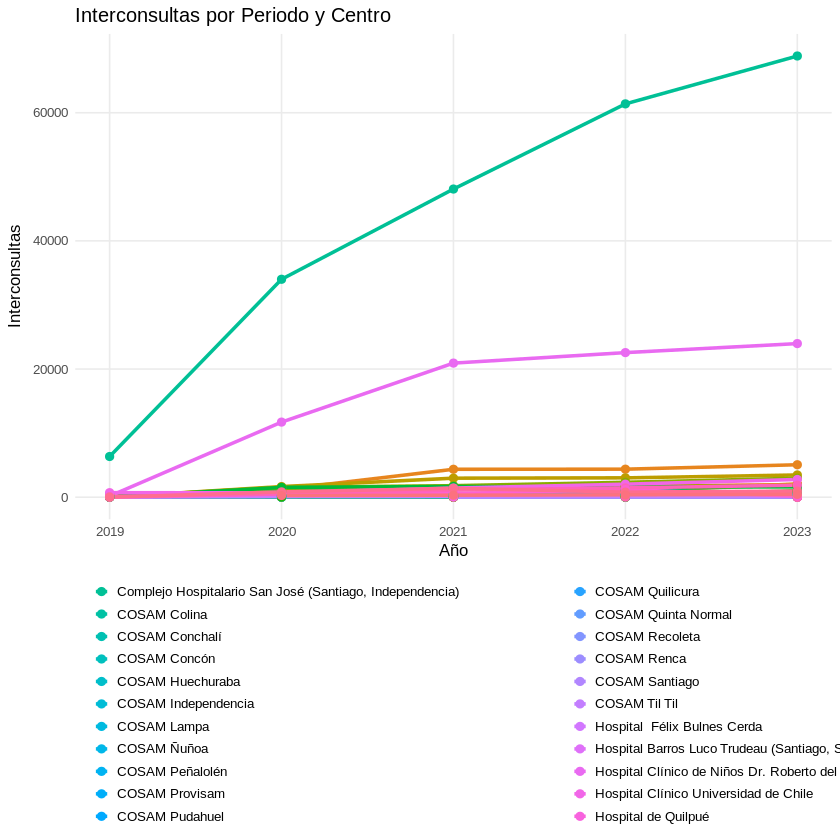

In [10]:
# Generamos una función que toma como parámetro el nombre de la serie:
# 'Consultas_producidas', 'Consultas_inasistencia', 'Oferta_consultas', 'Consultas_solicitadas', 'Lista_espera_inicial'

graficar_serie <- function(serie) {

  # 1. Agrupar y resumir total de datos por año y centro,
  #usando .data[[ ]] para que acepte el string directamente
  df <- cubo %>%
    dplyr::group_by(Año, Centro) %>%
    dplyr::summarise(Total = sum(.data[[serie]], na.rm = TRUE), .groups = "drop")

 # 2. Creamos el gráfico con ggplot2
  p <- ggplot(df, aes(x = Año, y = Total, color = Centro, group = Centro)) + #Importante agrupar por centro,
    #para qe los gráficos tengan continuidad.
    #añadimos lineas para cada tendencia
    geom_line(size = 1) +
    #añadimos puntos para cada dato
    geom_point(size = 2) +
    #definimos etiqueta del eje y título
    labs(
      title = paste(serie, "por Periodo y Centro"),
      y = serie,
      x = "Año"
    ) +
    #diseño minimalista
    theme_minimal(base_size = 10) + # Tamaño de fuente más pequeño
    theme(
      legend.position = "bottom",    # Leyenda abajo para dar ancho al gráfico
      legend.title = element_blank(), # Elimina el texto "Centro" de la leyenda
      legend.text = element_text(size = 8), # Texto de leyenda pequeño
      legend.key.size = unit(0.3, "cm"),    # Símbolos de leyenda pequeños
      panel.grid.minor = element_blank()    # Limpia el fondo
    )

  return(p)
}

# Ejecutamos la función
graficar_serie("Interconsultas")

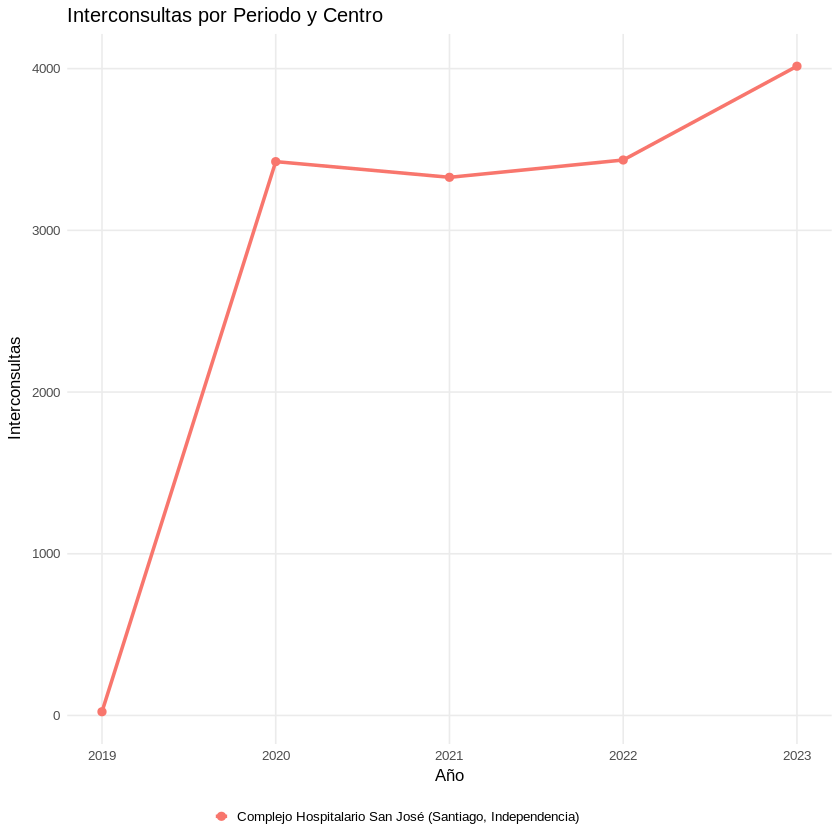

In [11]:
# También podemos agregar un parámetro que permita filtrar por especialidad

graficar_serie_especialidad <- function(serie, especialidad) {

  # 1. Agrupar y resumir total de datos por año y centro,
  #usando .data[[ ]] para que acepte el string directamente

  # generamos una variable para filtrar por especialidad, también con .data[[ ]]
  df <- cubo %>%
    dplyr::filter(Especialidad== especialidad) %>%
    dplyr::group_by(Año, Centro) %>%
    dplyr::summarise(Total = sum(.data[[serie]], na.rm = TRUE), .groups = "drop")

 # 2. Creamos el gráfico con ggplot2
  p <- ggplot(df, aes(x = Año, y = Total, color = Centro, group = Centro)) +
    geom_line(size = 1) +
    geom_point(size = 2) +
    labs(
      title = paste(serie, "por Periodo y Centro"),
      y = serie,
      x = "Año"
    ) +
    theme_minimal(base_size = 10) +
    theme(
      legend.position = "bottom",
      legend.title = element_blank(),
      legend.text = element_text(size = 8),
      legend.key.size = unit(0.3, "cm"),
      panel.grid.minor = element_blank()
    )+
    # Forzar la leyenda a una sola columna
    guides(color = guide_legend(ncol = 1))

  return(p)
}

# Ejecutamos la función
graficar_serie_especialidad("Interconsultas", "OBSTETRICIA")

# Análisis

* ¿Cuál fue la demanda de interconsultas de Gastroenterología y Coloproctología por centro entre 2019 y 2023?
* ¿Cuál fue la demanda de interconsultas de Pediatría el 2023?
* ¿Qué otra pregunta podría responder utilizando esta base de datos y funciones presentadas aquí?
